In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from bayesfilt.filters import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
from bayesfilt.models import ConstantVelocity1D, LinearObservationModel
from bayesfilt.models import CTRV_POINT

In [4]:
# generate observations
np.random.seed(30)
dt_true = 0.1
nsamples = 100
tlist = np.linspace(0,nsamples*dt_true, nsamples)
y_true = np.sin(1.*tlist) 
ylist = y_true + 0.1*np.random.randn(nsamples)

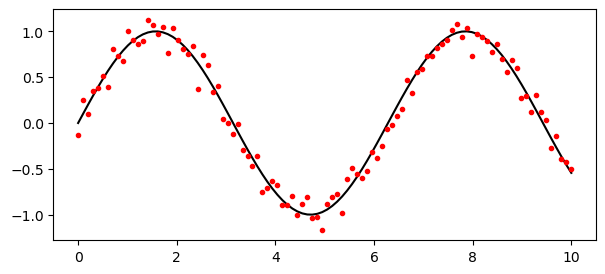

In [5]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(tlist, y_true, '-k')
ax.plot(tlist, ylist, '.r')

In [6]:
# dynamics model
mm = ConstantVelocity1D()
mm.phi = dict(sigma=0.2)
mm.update_matrices(dt=0.05)
mm

----ConstantVelocity1D----
States    (2): PositionX,VelocityX
Parameters(1): sigma=0.2

In [7]:
# observation model
om = LinearObservationModel(nx=2, observed_state_inds=[0])
om

----ObservationModel----
States    (2): x_0,x_1
Parameters(0): 
Obs States(1): x_0

In [8]:
# kalman filter
kf = KalmanFilter(
    nx=mm.nx,
    ny=om.ny,
    dt=0.05,
    mat_F=mm.F,
    mat_H=om.H,
    mat_Q=mm.Q
)
print(kf)

KalmanFilter: Setting dt_tol to 0.025
KalmanFilter: Setting mat_G as identity matrix!
KalmanFilter: Setting mat_J as identity matrix!
KalmanFilter(nx=2, ny=1, dt=0.05, dt_tol=0.025, epsilon=1e-06, verbose=False)


In [9]:
# initiate and run
kf.initiate(
    t0=tlist[0],
    m0=[ylist[0],0],
    P0=np.diag([0.1, 0.1]),
    flag='Update'
)
kf.filter(
    list_of_t=tlist[1:],
    list_of_y=ylist[1:],
    list_of_R = np.diag([0.1**2])
)
kf.smoother()

KalmanFilter: Initiating filter at 0.0 sec..
KalmanFilter(S): 100%|██████████| 300/300 [00:01<00:00, 194.70it/s]


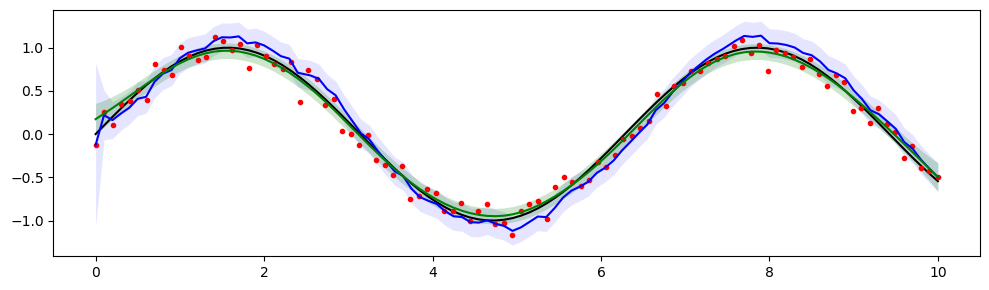

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tlist, y_true, '-k')
ax.plot(tlist, ylist, '.r')
# filter
updates = kf.logger.flag() =='Update'
ax.plot(kf.logger.time_elapsed[updates], kf.logger.state_mean(0)[updates], '-b')
ax.fill_between(
    kf.logger.time_elapsed[updates], 
    kf.logger.state_mean(0)[updates] - 3*np.sqrt(kf.logger.state_var(0)[updates]), 
    kf.logger.state_mean(0)[updates] + 3*np.sqrt(kf.logger.state_var(0)[updates]),
    color='b', alpha=0.1, lw=0
)
# smoother
updates = kf.slogger.flag()=='Update'
ax.plot(kf.slogger.time_elapsed[updates], kf.slogger.state_mean(0)[updates], '-g')
ax.fill_between(
    kf.slogger.time_elapsed[updates], 
    kf.slogger.state_mean(0)[updates] - 3*np.sqrt(kf.slogger.state_var(0)[updates]), 
    kf.slogger.state_mean(0)[updates] + 3*np.sqrt(kf.slogger.state_var(0)[updates]),
    color='g', alpha=0.2, lw=0
)
fig.tight_layout()